In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [2]:
for i in train_iter:
    print(i)
    print(len(i))
    break

(tensor([[ 6,  0, 21,  ...,  3,  6,  0],
        [ 0,  2, 15,  ...,  2, 10, 19],
        [ 2, 21,  0,  ..., 15,  6, 20],
        ...,
        [ 0,  4, 16,  ...,  0,  3, 22],
        [ 4, 19, 26,  ..., 14, 22, 20],
        [ 6,  0, 14,  ..., 10, 19,  0]]), tensor([[ 0, 21, 10,  ...,  6,  0,  4],
        [ 2, 15,  5,  ..., 10, 19, 20],
        [21,  0,  2,  ...,  6, 20, 20],
        ...,
        [ 4, 16, 15,  ...,  3, 22, 21],
        [19, 26, 20,  ..., 22, 20, 21],
        [ 0, 14,  6,  ..., 19,  0,  2]]))
2


In [3]:
vocab[1]

1

In [4]:
F.one_hot(torch.tensor([0,3]),10)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [5]:
X=torch.arange(10).reshape((2,5))
F.one_hot(X.T,28).shape

torch.Size([5, 2, 28])

In [6]:
#初始化模型参数

def get_params(vocab_size,num_hiddens,device):
    num_inputs=num_outputs=vocab_size

    def normal(shape):
        return torch.randn(size=shape,device=device)
    
    #隐藏层
    W_xh=normal((num_inputs,num_hiddens))

    W_hh=normal((num_hiddens,num_hiddens))

    b_h=torch.zeros(num_hiddens,device=device)

    #输出层
    W_hq=normal((num_hiddens,num_outputs))
    b_q=torch.zeros(num_outputs,device=device)

    params=[W_xh,W_hh,b_h,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)

    return params


循环神经网络模型

In [7]:
def init_rnn_state(batch_size,num_hiddens,device):
    return (torch.zeros((batch_size,num_hiddens),device=device),)

In [8]:
def rnn(inputs,state,params):
    W_xh, W_hh, b_h, W_hq, b_q=params
    H, =state
    outputs=[]

    for X in inputs:
        H=torch.tanh(torch.mm(X,W_xh) + torch.mm(H, W_hh) + b_h)
        Y=torch.mm( H, W_hq)+ b_q
        outputs.append(Y)

    return torch.cat(outputs,dim=0),(H,)

In [38]:
class RNNModelScratch:
    def __init__(self,vocab_size,num_hiddens,device,
                 get_params,init_state,forward_fn):
        self.vocab_size=vocab_size
        self.num_hiddens=num_hiddens
        self.params=get_params(vocab_size,num_hiddens,device)
        self.init_state=init_state
        self.forward_fn=forward_fn

    def __call__(self,X,state):
        X=F.one_hot(X.T,self.vocab_size).type(torch.float32)
        return self.forward_fn(X,state,self.params)
    
    def begin_state(self,batch_size,device):
        return self.init_state(batch_size,self.num_hiddens,device)
    

In [39]:
num_hiddens=32

net=RNNModelScratch(len(vocab),num_hiddens,d2l.try_gpu(),
                   get_params,init_rnn_state,rnn)
state=net.begin_state(X.shape[0],d2l.try_gpu())

Y,new_state=net(X.to(d2l.try_gpu()),state)

Y.shape,len(new_state), new_state[0].shape


(torch.Size([10, 28]), 1, torch.Size([2, 32]))

In [11]:
num_hiddens=512
net=RNNModelScrach(len(vocab),num_hiddens,d2l.try_gpu(),
                   get_params,init_rnn_state,rnn)

state=net.begin_state(X.shape[0],d2l.try_gpu())

Y,new_state=net(X.to(d2l.try_gpu()),state)

Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [12]:
#预测

def predict_ch8(prefix,num_preds,net,vocab,device):
    state=net.begin_state(batch_size=1,device=device)
    outputs=[vocab[prefix[0]]]
    get_input=lambda: torch.tensor([outputs[-1]],device=device).reshape((1,1))

    for y in prefix[1:]:
        _,state=net(get_input(),state)
        outputs.append(vocab[y])

    for _ in range(num_preds):
        y,state=net(get_input(),state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])
    

In [13]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller yfqtqx<unk>p<unk>v'

In [14]:
#梯度剪裁

def grad_clipping(net,theta):
    if isinstance(net,nn.Module):
        params=[p for p in net.parameters() if p.requires_grad]
    else:
        params=net.params
    norm=torch.sqrt(sum(torch.sum( (p.grad**2)) for p in params))

    if norm>theta:
        for param in params:
            param.grad[:]*=theta/norm



In [33]:
def train_epoch(net,train_iter,loss,updater,device,use_random_iter):
    state,timer=None,d2l.Timer()
    metric=d2l.Accumulator(2)

    for X,Y in train_iter:
        if state is None or use_random_iter:
            state=net.begin_state(batch_size=X.shape[0],device=device)
        else:
            if isinstance(net,nn.Module) and not isinstance(state,tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()

        y=Y.T.reshape(-1)
        X,y=X.to(device),y.to(device)
        y_hat,state=net(X,state)
        l=loss(y_hat,y.long()).mean()

        if isinstance(updater,torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net,1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net,1)
            updater(batch_size=1)

        metric.add(l*y.numel(),y.numel())

    return math.exp(metric[0]/metric[1]),metric[1]/timer.stop()




In [34]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 75322432669089890304.0, 78686.0 词元/秒 cuda:0
time travellerotq dhragprjvier<unk>zzteeq<unk><unk>muyrxrptttdpoacs<unk>plqyx<unk>ay
travellerkr zk  zhovqxa<unk>lhtblmohlyqgsg rfpgzpsyqobwk<unk>y ujkm


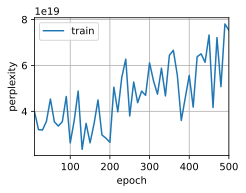

In [35]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 13.6, 77330.6 词元/秒 cuda:0
time traveller t t t t t t t t t t t t t t t t t t t t t t t t t
traveller the the the the the the the the the the the the t


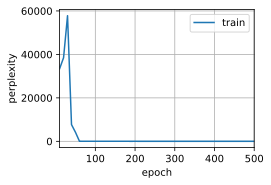

In [40]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)